## TP2: Visión por Computadora I (CEIA)
### Nombre: Pablo Segovia

Implementar la función create_gauss_filter(h, w, k_size, sigma)para crear filtros gaussianos para
filtrado espectral. Debe retornar un filtro gaussiano de tamaño HxW en dominio espacial y su transformada
de Fourier.

1. Graficar ambas representaciones para diferentes tamaños de kernel y sigma. Aplicar el filtro una
imagen para validar el funcionamiento en el dominio espectral.
2. Usando el método descripto en el paper“Image Sharpness Measure for Blurred Images in Frequency
Domain” comparar el resultado de un filtrado por convolución con el filtrado espectral.
3. Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper “Analysis of
focus measure operators in shape-from-focus”

In [1]:
# Importamos las librerías a utilizar
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

In [10]:
# Generamos la función que pide la consigna
def create_gauss_filter(h, w, k_size, sigma):
    # Generar el kernel gaussiano
    gaussian = cv.getGaussianKernel(ksize=k_size, sigma=sigma)
    
    # Transformar gaussiano en matricial
    gaussian = gaussian @ gaussian.T
    
    # Calculamos el tamaño del padding en ambas direcciones
    pad_w = (w-k_size)//2
    pad_h = (h-k_size)//2
    
    # Realizar un padding completando con ceros el kernel
    gaussian = np.pad(gaussian, pad_width=((pad_h,pad_h+1),(pad_w,pad_w)), mode='constant', constant_values=0)
    
    # Pasar el gaussiano por su transformada de furier 2D
    gaussian_fft = np.fft.fft2(gaussian)
    
    return gaussian, gaussian_fft
    
    

1. Graficar ambas representaciones para diferentes tamaños de kernel y sigma. Aplicar el filtro una
imagen para validar el funcionamiento en el dominio espectral.

#### Probamos una imagen para ver su impacto

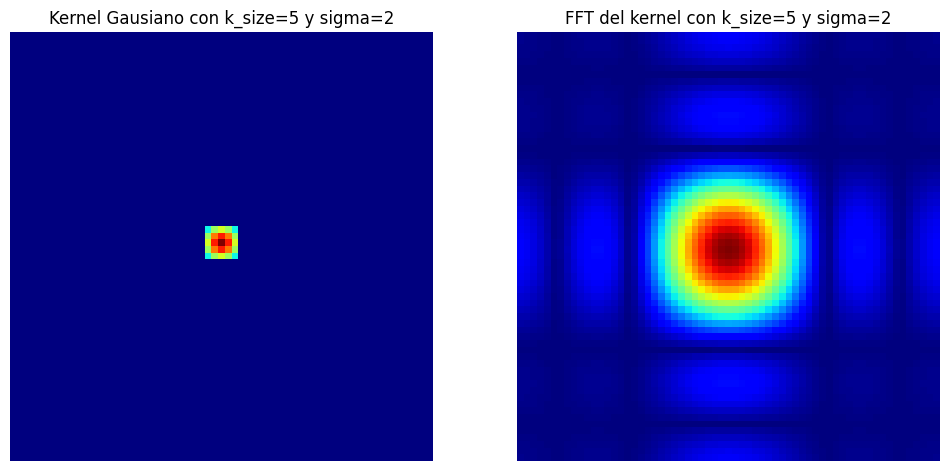

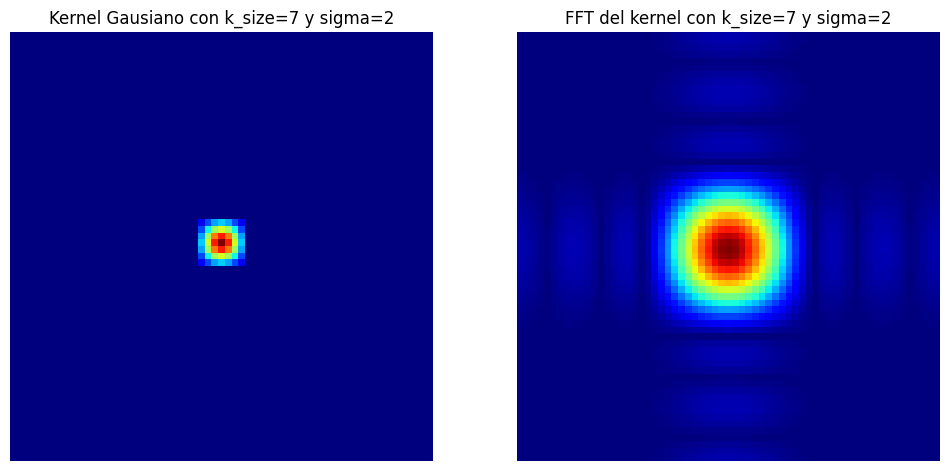

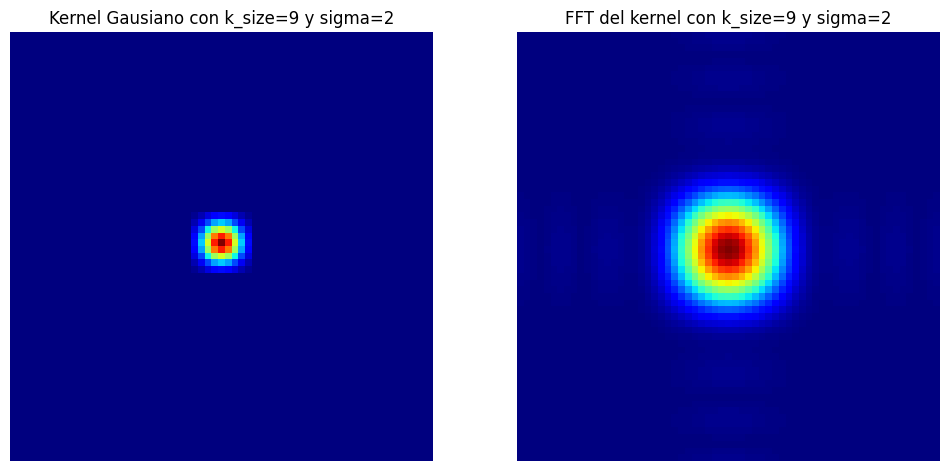

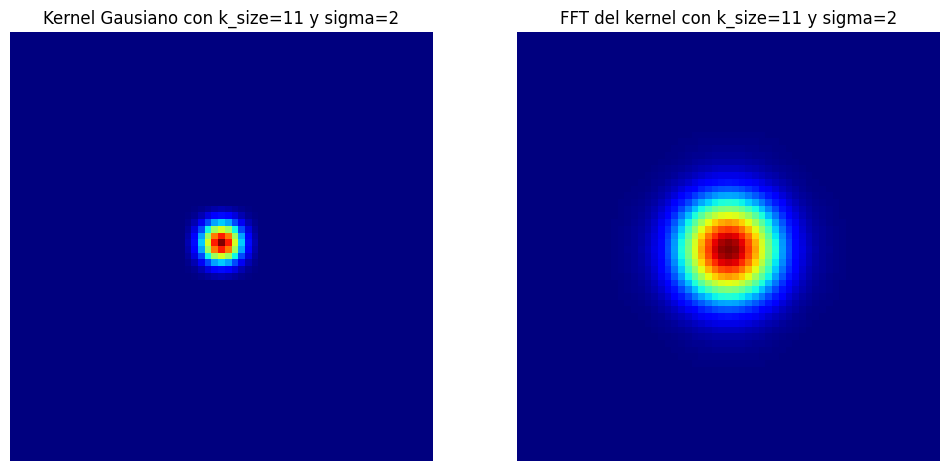

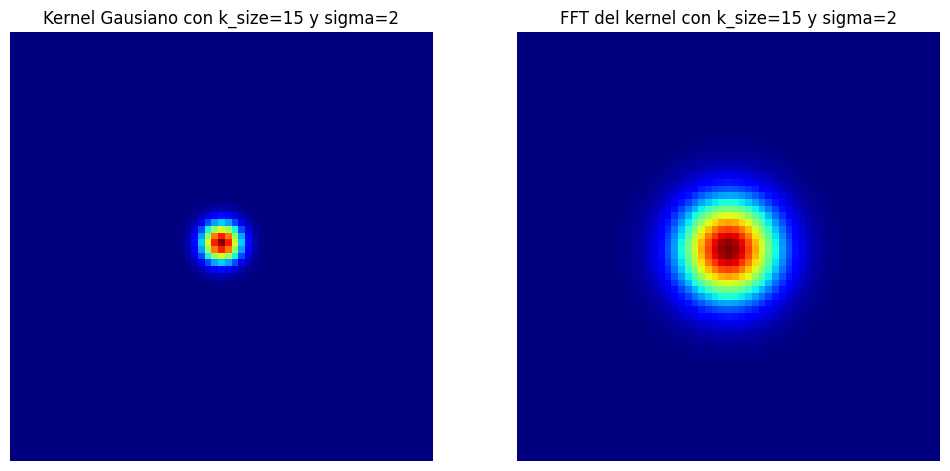

In [13]:
# Probamos diferentes tamaños de kernels
for size in [5, 7, 9, 11, 15]:
    kernel, kernel_tf = create_gauss_filter(h=64, w=64, k_size=size, sigma=2)

    plt.figure(figsize=(12,12))
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.title(f"Kernel Gausiano con k_size={size} y sigma={2}")
    plt.imshow(kernel, cmap='jet')
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.title(f"FFT del kernel con k_size={size} y sigma={2}")
    tf_shifted = np.fft.fftshift(kernel_tf)
    plt.imshow(np.abs(tf_shifted), cmap='jet');

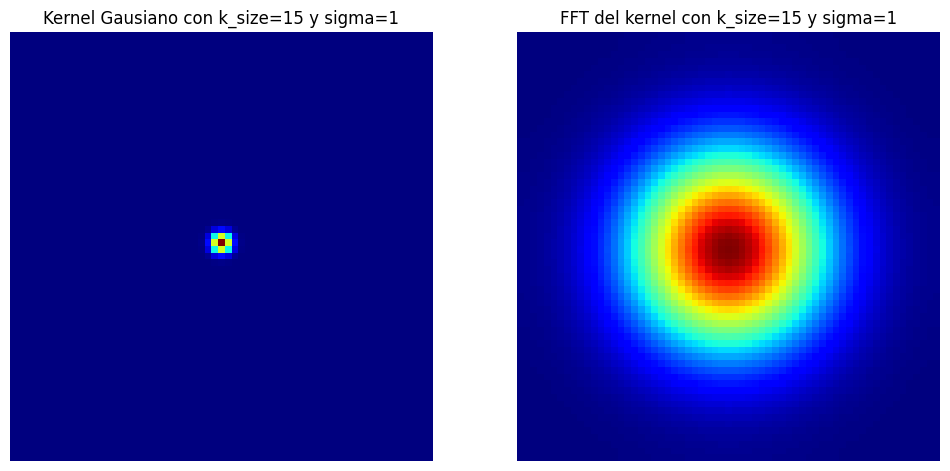

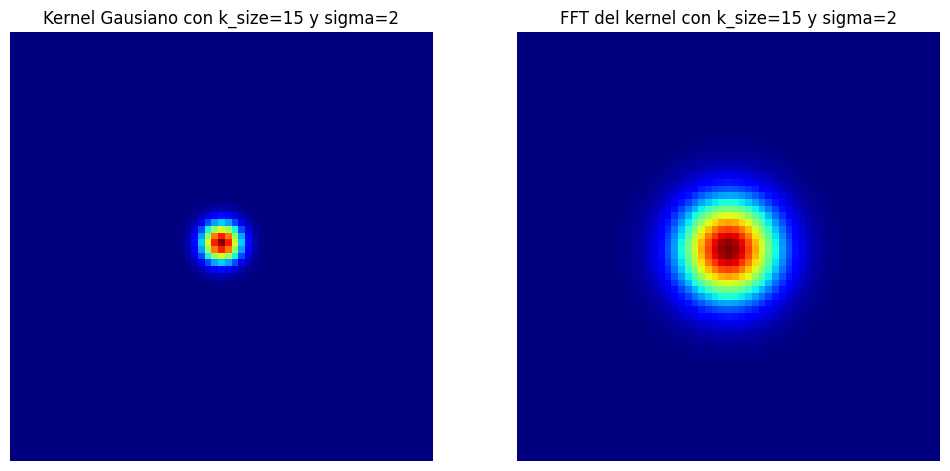

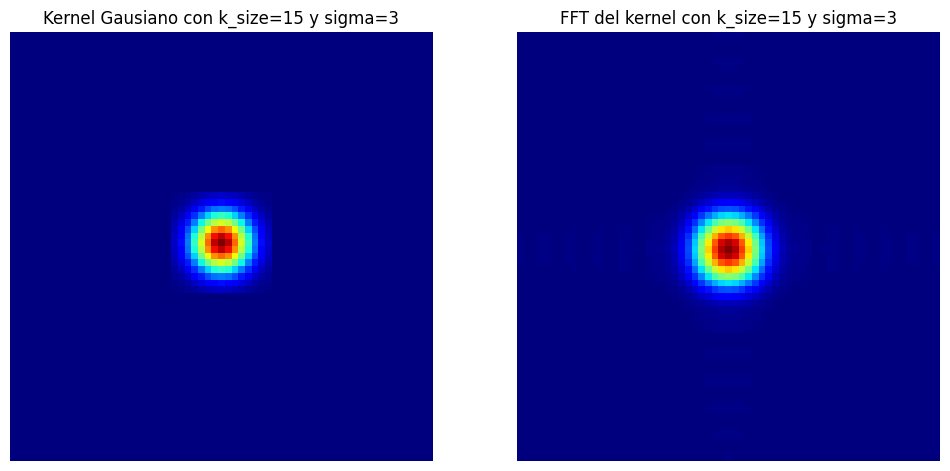

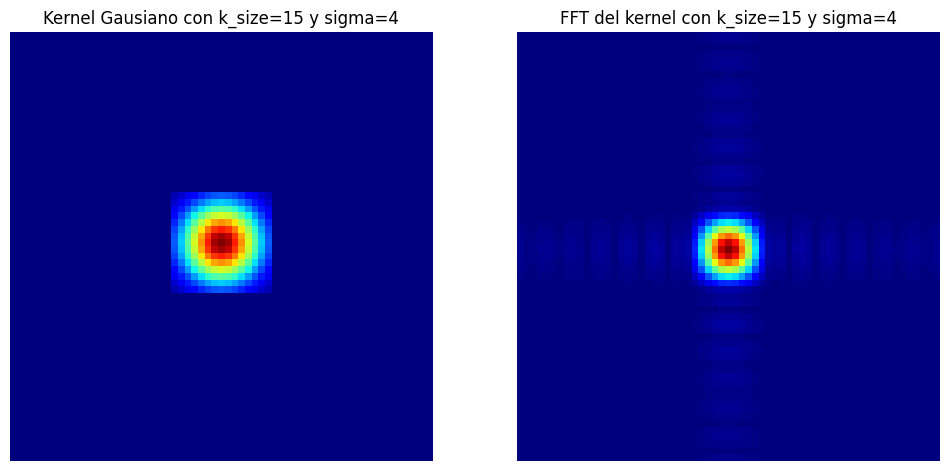

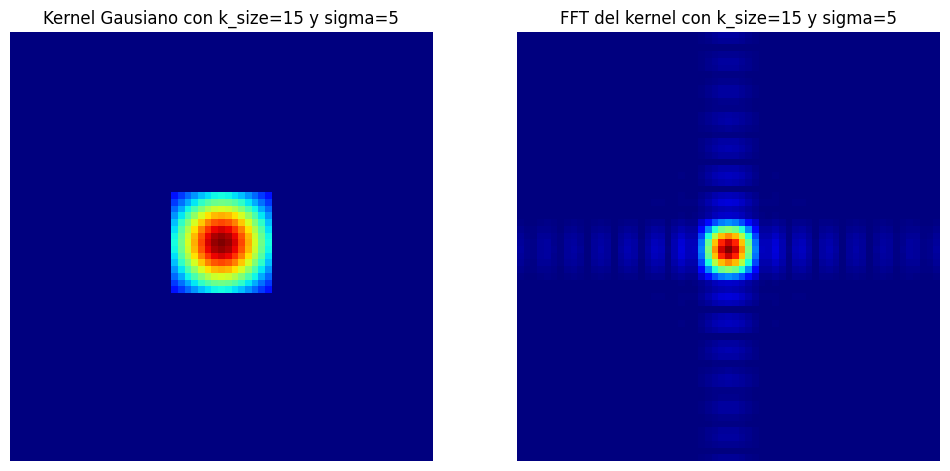

In [14]:
# Probamos diferentes sigmas
for sigma in [1, 2, 3, 4, 5]:
    kernel, kernel_tf = create_gauss_filter(h=64, w=64, k_size=15, sigma=sigma)

    plt.figure(figsize=(12,12))
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.title(f"Kernel Gausiano con k_size={15} y sigma={sigma}")
    plt.imshow(kernel, cmap='jet')
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.title(f"FFT del kernel con k_size={15} y sigma={sigma}")
    tf_shifted = np.fft.fftshift(kernel_tf)
    plt.imshow(np.abs(tf_shifted), cmap='jet');

- Completar explicación.

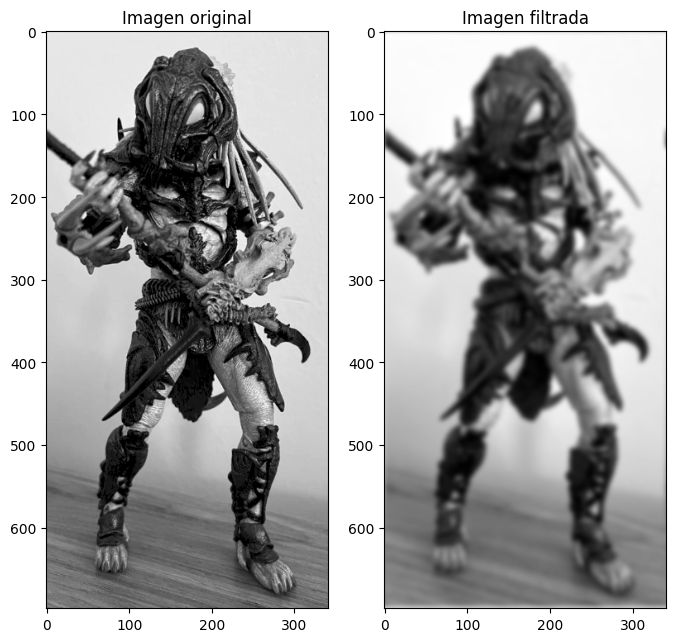

In [21]:
# Importamos la imagen así conocemos h y w
img = cv.imread('/Users/manoloacademia/Documents/CEIA/03 - Vision 1/vision_computadora_I/Codigo/Clase3/fft_alfa_pred.png',
                cv.IMREAD_GRAYSCALE)
h,w = img.shape
kernel, kernel_tf = create_gauss_filter(h, w, k_size=15, sigma=3.0)

# Definir la imagen en el dominio de los complejos
img_fft = np.fft.fft2(img)

# Aplicar el kernel gaussiano
img_fft = img_fft * kernel_tf

# Aplicamos la antitransformada y obtenemos las imagenes filtradas
img_fft = np.fft.ifftshift(np.real(np.fft.ifft2(img_fft)))

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title('Imagen original')
plt.subplot(1,2,2)
plt.title('Imagen filtrada')
plt.imshow(img_fft, cmap='gray');

2. Usando el método descripto en el paper“Image Sharpness Measure for Blurred Images in Frequency
Domain” comparar el resultado de un filtrado por convolución con el filtrado espectral.

In [4]:
# Aplicamos el método del paper
f = np.fft.fft2(img)
fc = np.fft.fftshift(f)
af = np.abs(fc)
m = np.max(af)

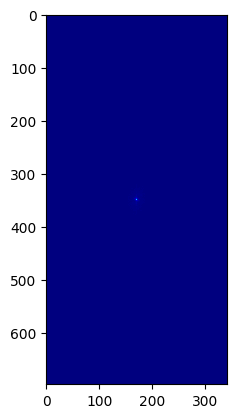

In [5]:
plt.figure()
plt.imshow(af, cmap='jet');